In [37]:

import os
import pandas as pd


home = os.environ["HOME"]
os.chdir(f"{home}/tiniMLVM")
sensor_data_folder = "smart_city/spire_2023.csv"
df = pd.read_csv(sensor_data_folder, sep=";")

#get max value of chiave
max_value = df["chiave"].max()
print(max_value)

df.head()

949.0


,data,codice_spira,00_00_01_00,01_00_02_00,02_00_03_00,03_00_04_00,04_00_05_00,05_00_06_00,06_00_07_00,07_00_08_00,...,ordinanza,stato,codimpsem,direzione,angolo,longitudine,latitudine,geopoint,chiave,num_giorno_settimana
0,2023-04-01,0.127 1.5 2 1,34,31,14,7,9,12,22,48,...,4000/343434,A,250,S,163.0,11.343595,44.501688,"44.5016875497437, 11.3435953508993",16.0,Sabato
1,2023-04-01,0.127 1.5 5 1,38,29,20,6,13,12,18,21,...,4000/343434,A,250,N,343.0,11.343408,44.501173,"44.5011734938257, 11.3434083495971",17.0,Sabato
2,2023-04-01,0.127 1.13 6 1,0,0,0,0,0,0,0,0,...,4000/343434,A,323,S,198.0,11.346420,44.491648,"44.4916483847646, 11.3464200565732",3.0,Sabato
3,2023-04-01,0.127 1.15 6 1,68,50,38,13,12,18,32,43,...,4000/343434,A,324,S,168.0,11.343443,44.490027,"44.4900271601578, 11.3434427397635",7.0,Sabato
4,2023-04-01,0.127 1.82 2 2,86,55,37,30,27,23,51,119,...,4000/343434,A,85,SE,217.0,11.349800,44.490458,"44.4904584072207, 11.34979980231",20.0,Sabato


In [35]:
print(df.columns)

Index(['data', 'codice_spira', '00_00_01_00', '01_00_02_00', '02_00_03_00',
       '03_00_04_00', '04_00_05_00', '05_00_06_00', '06_00_07_00',
       '07_00_08_00', '08_00_09_00', '09_00_10_00', '10_00_11_00',
       '11_00_12_00', '12_00_13_00', '13_00_14_00', '14_00_15_00',
       '15_00_16_00', '16_00_17_00', '17_00_18_00', '18_00_19_00',
       '19_00_20_00', '20_00_21_00', '21_00_22_00', '22_00_23_00',
       '23_00_24_00', 'id_uni', 'livello', 'tipologia', 'codice',
       'codice_arco', 'codice_via', 'nome_via', 'nodo_da', 'nodo_a',
       'ordinanza', 'stato', 'codimpsem', 'direzione', 'angolo', 'longitudine',
       'latitudine', 'geopoint', 'chiave', 'num_giorno_settimana'],
      dtype='object')


In [38]:
#get a spire key and save all his values at rows in a file
import numpy as np 

def get_distance(lat1, lon1, lat2, lon2):
    r = 6371  # Radius of the earth in km

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = r * c  # Distance in km
    return distance

def get_spire_key_values(key,position_range, distance_max,df):
    spire_key = df[df["chiave"] == key]

    if spire_key.empty:
        return 0

    position = spire_key["geopoint"].values[0]

    position = [float(i) for i in position.split(",")]

    #check if the position is in the range
    distance = get_distance(position[0], position[1], position_range[0], position_range[1])

    if distance > distance_max:
        return 0

    #drop the non 2 to 25 columns 
    columns_keep = [df.columns[i] for i in range(2, 26)]
    spire_key = spire_key[columns_keep]
    #stack the columns in a single column
    spire_key = spire_key.stack()
    #append the values to a file of the same key

    with open(f"sensor_manager/sensor_data/spire_{key}_{position}.csv", "a") as f:
        spire_key.to_csv(f, index=False, header=False)
        
    spire_key.to_csv(f"sensor_manager/sensor_data/spire_{key}_{position}.csv", index=False, header=False) #8713

    return 1

i= 0
count = 0
number = 160
list_keys = []
bologna_position = [44.494887, 11.342616]
while count < number and i < int(max_value):
    i += 1
    if i == 3:
        continue
    adding = get_spire_key_values(i, bologna_position, 1, df)
    count += adding
    if adding:
        list_keys.append(i)


In [3]:
# print on the map the position of the sensors

import folium

m = folium.Map(location=[44.49381, 11.33875], zoom_start=15)

radius = 150


colors = []
for i in range(number):
    color = [np.random.randint(0, 255) for i in range(3)]
    #transform values to hex
    color = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
    colors.append(color)


for j,i in enumerate(list_keys):
    # color = colors[j]
    color = "red"
    spire_key = df[df["chiave"] == i]

    position = spire_key["geopoint"].values[0]
    position = [float(i) for i in position.split(",")]
    

    folium.Marker(
        location=position,
        icon=folium.Icon(color='blue', icon='4')
    ).add_to(m)

     #marker with number
    folium.Marker(
        location=position,
        icon = folium.DivIcon(
            icon_size=(150,36),
            icon_anchor=(7,20),
            html=f'<div style="font-size: 18pt; color: {color}">{i}</div>',
            )
        ).add_to(m)

   
    

    folium.Circle(
        radius=radius,
        location=position,
        color="blue",
        fill=False,
        line_cap='round',
    ).add_to(m)

    # folium.Circle(
    #     radius=40,
    #     location=position,
    #     color="black",
    #     fill=False,
    #     line_cap='round',
    # ).add_to(m)

#connect sensors with a line if they are inside the range

for i in range(len(list_keys)):
    for j in range(i+1, len(list_keys)):
        spire_key1 = df[df["chiave"] == list_keys[i]]
        spire_key2 = df[df["chiave"] == list_keys[j]]

        position1 = spire_key1["geopoint"].values[0]
        position1 = [float(i) for i in position1.split(",")]

        position2 = spire_key2["geopoint"].values[0]
        position2 = [float(i) for i in position2.split(",")]

        distance = get_distance(position1[0], position1[1], position2[0], position2[1])

        if distance < radius*1e-3:
            folium.PolyLine([position1, position2], color="black").add_to(m)


m

In [25]:
#count number of checks done, number of drifts and their type

data_manager_folder = "sensor_manager/manager_data/"

number_of_checks = 0
anomalous_drifts = 0
systematic_drifts = 0

local_pvalues = []
systematic_pvalues = []

for spire in list_keys:
    #read file
    with open(f"{data_manager_folder}output_{spire}.txt", "r") as f:
        lines = f.readlines()

    for line in lines:
        if "Local" in line:
            anomalous_drifts += 1
            number_of_checks += 1
            local_pvalues.append(float(line.split("=")[-1]))
        if "Systematic" in line:
            systematic_drifts += 1
            number_of_checks += 1
            systematic_pvalues.append(float(line.split("=")[-1]))
        if "No" in line:
            number_of_checks += 1
    
    number_of_drifts = anomalous_drifts + systematic_drifts

print(f"Number of checks: {number_of_checks}")
print(f"Number of drifts: {number_of_drifts}")
print(f"Number of anomalous drifts: {anomalous_drifts}")
print(f"Number of systematic drifts: {systematic_drifts}")

#print percentage of dirfts 

if number_of_checks != 0:
    #percentage of drifts
    print(f"Percentage of drifts: {number_of_drifts/number_of_checks*100:.2f}%")
    print(f"Percentage of anomalous drifts: {anomalous_drifts/number_of_drifts*100:.2f}%")


#plot p_value of the drifts, separating local from systematic

import matplotlib.pyplot as plt
import numpy as np


plt.figure()

#normalize pvalues
local_pvalues = np.array(local_pvalues)
systematic_pvalues = np.array(systematic_pvalues)
local_pvalues = (local_pvalues - local_pvalues.min())/(local_pvalues.max() - local_pvalues.min())


systematic_pvalues = (systematic_pvalues - systematic_pvalues.min())/(systematic_pvalues.max() - systematic_pvalues.min())

#calculate the histogram with numpy
local_hist, bins = np.histogram(local_pvalues, bins=100)

local_hist = local_hist/local_hist.sum()


systematic_hist, bins = np.histogram(systematic_pvalues, bins=100)

systematic_hist = systematic_hist/systematic_hist.sum()


plt.bar(bins[:-1], local_hist, alpha=0.4, label="Local drifts", width=0.01, align="edge")
plt.bar(bins[:-1], systematic_hist, alpha=0.4, label="Systematic drifts", width=0.01, align="edge")

# #logarithmic scale x axis
plt.legend(loc='upper right')

plt.show()

# plt.plot(bins)
# # plt.yscale("log")
# plt.show()

Number of checks: 145
Number of drifts: 18
Number of anomalous drifts: 18
Number of systematic drifts: 0
Percentage of drifts: 12.41%
Percentage of anomalous drifts: 100.00%


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 640x480 with 0 Axes>

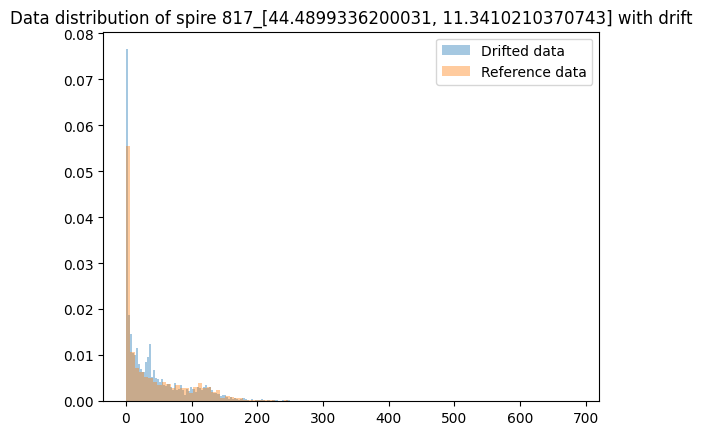

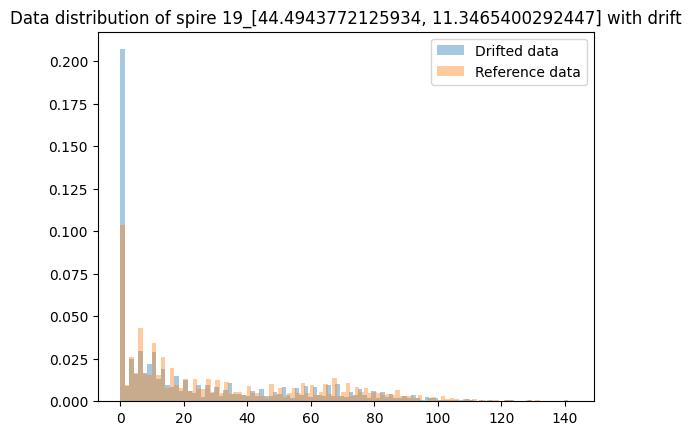

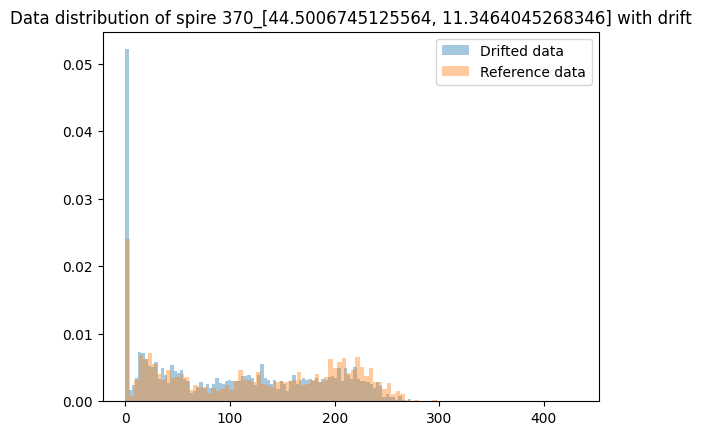

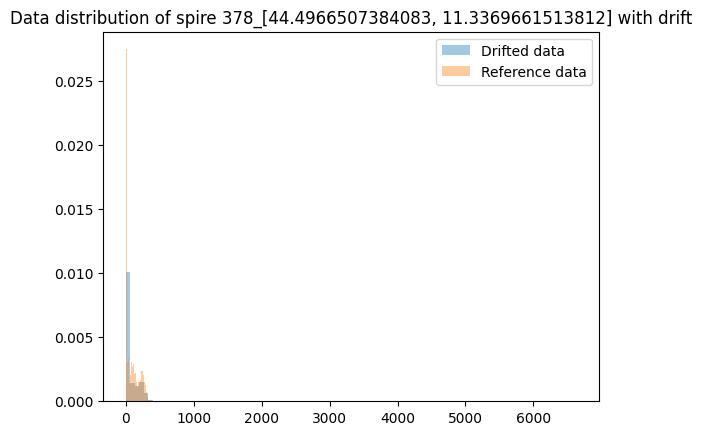

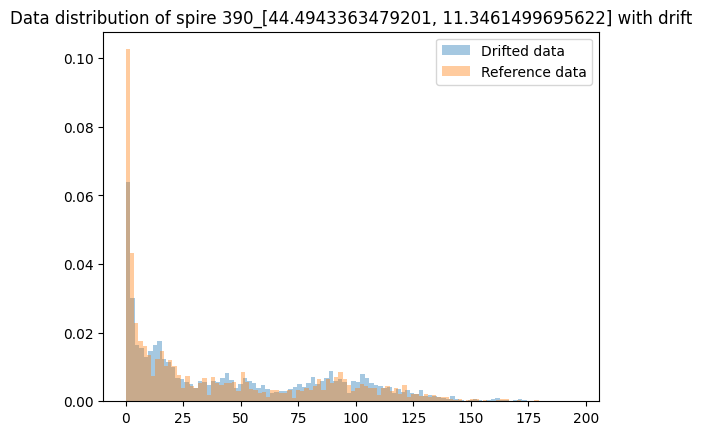

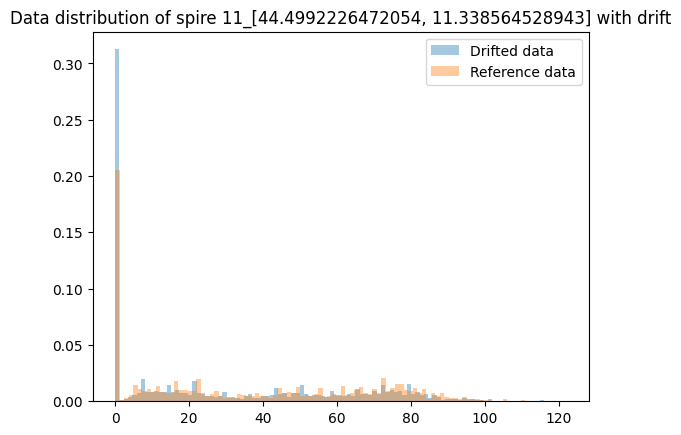

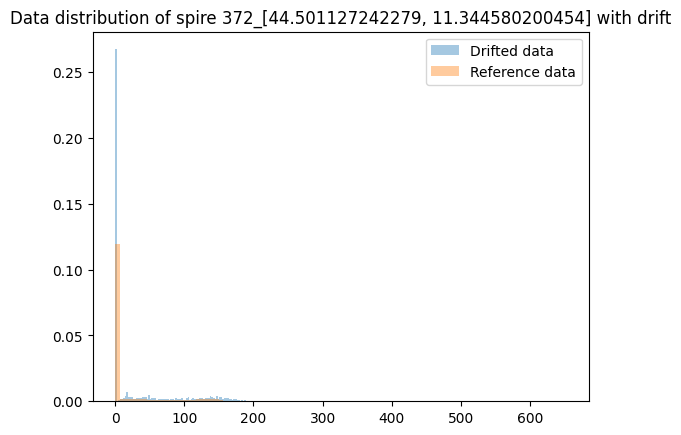

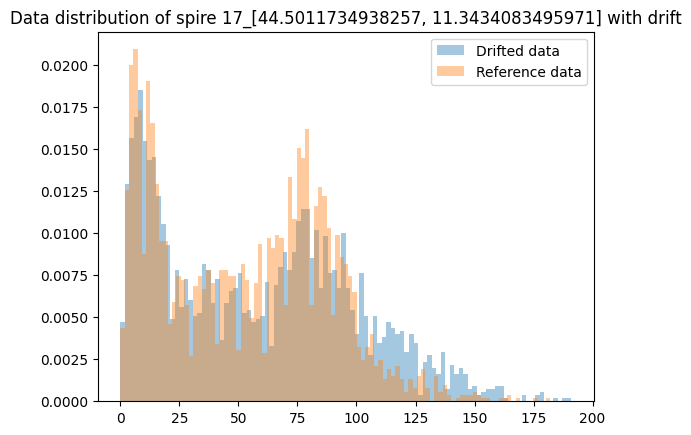

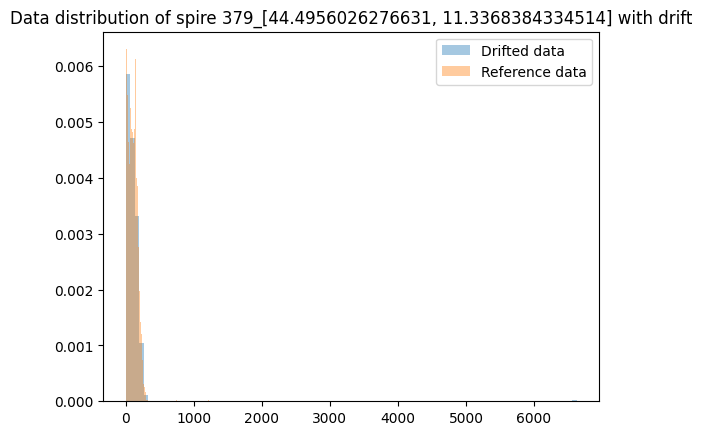

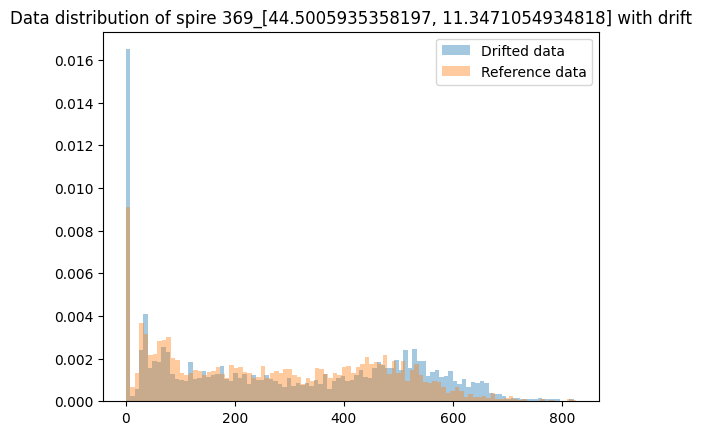

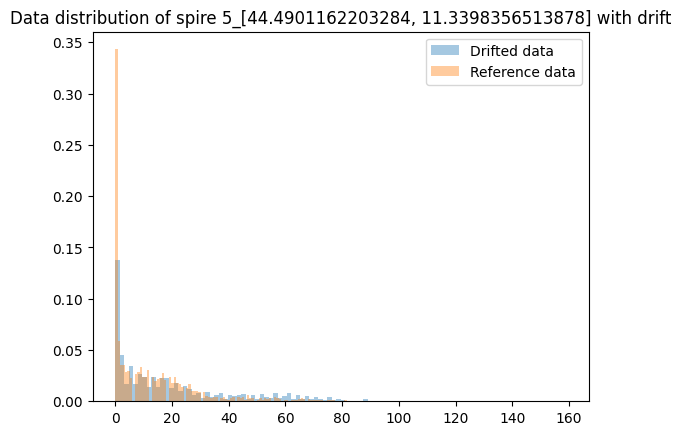

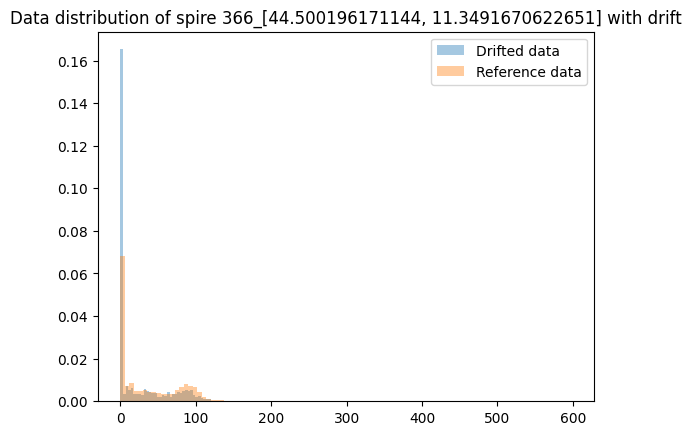

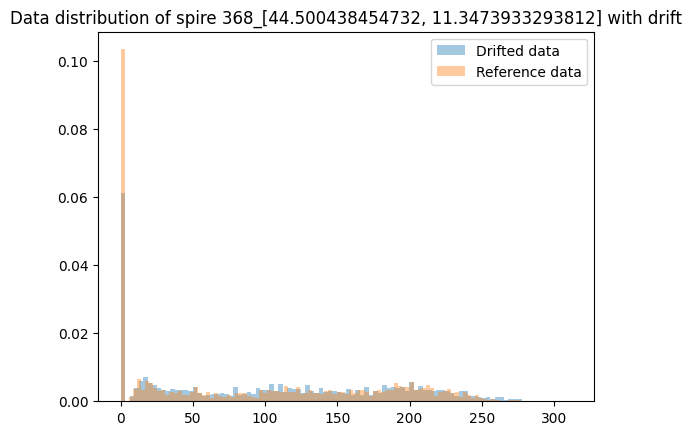

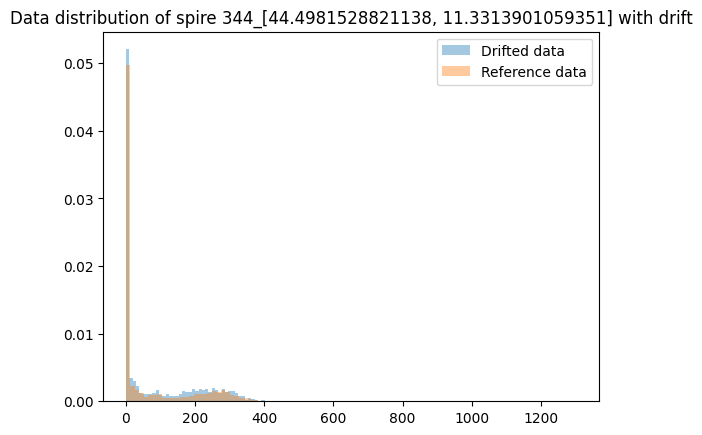

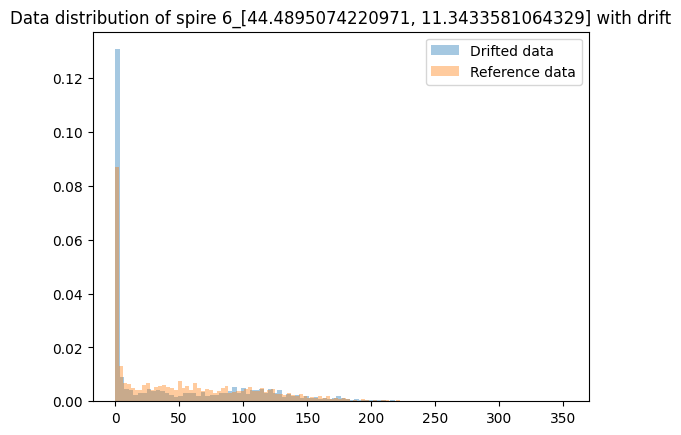

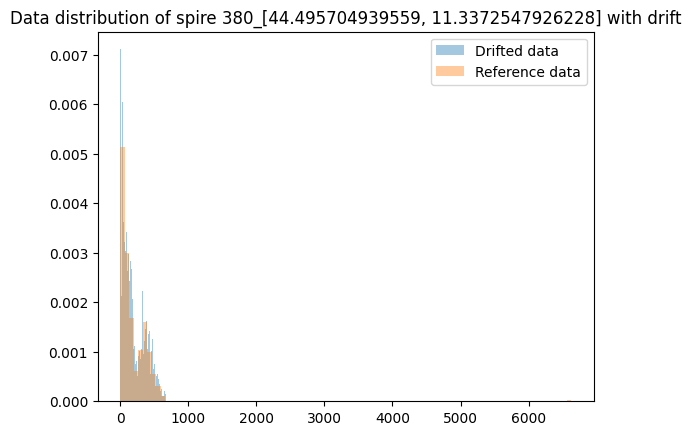

In [24]:
#show data distributiion when a drift is detected
import os
data_spire_folder = "sensor_manager/spire/"

#read data from the folder

# check_list = [""]

for file in os.listdir(data_spire_folder):
    for file_in in os.listdir(data_spire_folder+file):
        #if file in starts with localdrift, then print his distribution with the corresponding reference distribution
        if "localdrift" in file_in:
            #get reference number
            reference = file_in.split("_")[2][:-4]

            reference_file = "reference_"+reference+".csv"           

            #read data

            data_drifted = pd.read_csv(data_spire_folder+file+"/"+file_in)
            reference_data = pd.read_csv(data_spire_folder+file+"/"+reference_file)

            #plot data

            plt.figure()

            plt.title(f"Data distribution of spire {file} with drift")

            plt.hist(data_drifted, bins=100, alpha=0.4, label="Drifted data", density=True)
            plt.hist(reference_data, bins=100, alpha=0.4, label="Reference data", density=True)

            plt.legend(loc='upper right')

            plt.show()





In [ ]:
#generate data with generated drifts and attacks(anomalous drifts)
import os 
import pandas as pd
import numpy as np

# df = pd.read_csv("./sensor_data/spire_1_[44.4985349106485, 11.3541657967424].csv")

#read multiple files in the same dataframe

files = os.listdir("./sensor_data")
df = pd.read_csv(f"./sensor_data/{files[0]}")
for file in files[1:]:
    df = pd.concat([df, pd.read_csv(f"./sensor_data/{file}")], axis=1)

#set columns names as integers
df.columns = range(df.shape[1])


reference_length = 30*24*3 #3 months of data

#cut a month of data
df_ref = df.iloc[:reference_length].copy()

print(df_ref.shape)

#get mean value of each column
current_mean = df_ref.mean(axis=0).values

#create a dataset with drifts and attacks
length_dataset = 12
df_final = df_ref.copy()

decided_labels = ["attack", "drift", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal", "normal"]

labels = []

for j in range(length_dataset):
    #select attack,drift or normal
    # type_of_attack = np.random.choice(["attack", "drift", "normal"], p=[0.2, 0.2, 0.6]).item()
    type_of_attack = decided_labels[j]

    df = df_ref.copy()

    if type_of_attack == "attack":
        #select a column to attack
        column = np.random.choice(df.columns)
        #select a value to attack
        value = current_mean[column]

        df[column] = df[column].apply(lambda x: x + value)
    
    elif type_of_attack == "drift":
        #select a value to drift
        current_mean = current_mean*2
        #drift the value
        for column in df.columns:
            df_ref[column] = df_ref[column].apply(lambda x: x + current_mean[column])
            df[column] = df[column].apply(lambda x: x + current_mean[column])

    elif type_of_attack == "normal":
        pass

    df_final = pd.concat([df_final, df], axis=0)
    labels.append(type_of_attack)

print(df_final.shape)
print(labels)
    
#save the dataset and the labels splitting the columns

for i,file in enumerate(files):
    df_final[i].to_csv(f"./sintetic_data/{file}", index=False, header=False)

pd.DataFrame(labels).to_csv("./sintetic_data/labels.csv", index=False, header=False)



(2160, 2)
(28080, 2)
['drift', 'normal', 'normal', 'drift', 'normal', 'normal', 'attack', 'normal', 'drift', 'normal', 'normal', 'normal']


In [ ]:
import numpy as np
import math

#get geopoints

list_geopoints = []

for file in os.listdir(f"{home}/tiniMLVM/sensor_manager/sensor_data"):
    if "spire" in file:
        position = file.split("_")[-1].replace(".csv", "")
        lat1, lon1 = float(position.split(",")[0][1:]), float(position.split(",")[1][:-1])
        list_geopoints.append((lat1, lon1))


def get_distance(lat1, lon1, lat2, lon2):
    r = 6371  # Radius of the earth in km

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = r * c  # Distance in km
    return distance

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the Earth (specified in decimal degrees)
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1  # Difference in latitude
    dlon = lon2 - lon1  # Difference in longitude
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of Earth in kilometers (can be changed to 3958.8 for miles)
    r = 6371  # Radius of Earth in km
    distance = r * c  # Distance in km
    return distance


for i in range(len(list_geopoints)):
    for j in range(i + 1, len(list_geopoints)):
        distance = get_distance(list_geopoints[i][0], list_geopoints[i][1], list_geopoints[j][0], list_geopoints[j][1])
        print(f"Distance between {list_geopoints[i]} and {list_geopoints[j]} is {distance} km")

Distance between (44.4901162203284, 11.3398356513878) and (44.4985349106485, 11.3541657967424) is 1.4724961270775772 km
Distance between (44.4901162203284, 11.3398356513878) and (44.4985349106485, 11.3541657967424) is 1.4724961270775772 km


Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0248 - val_loss: 0.0090
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 12/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0

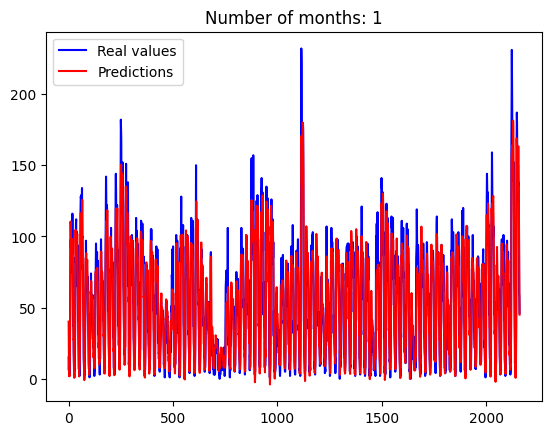

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


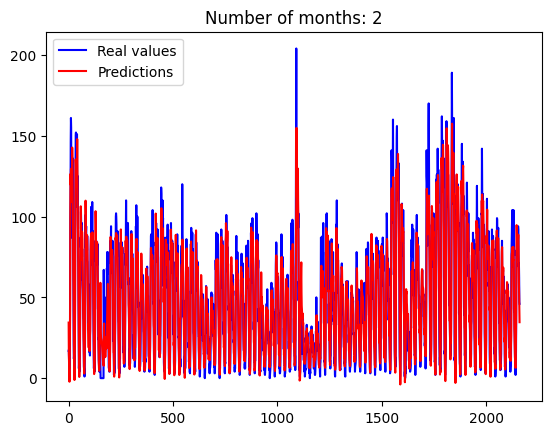

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0032
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


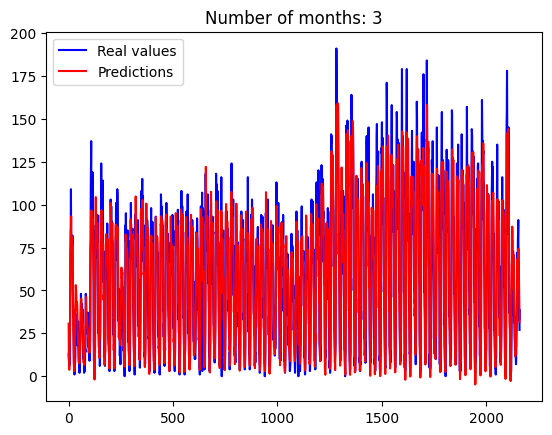

In [ ]:
#check if the model reduces his accuracy in time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#load the dataset

df = pd.read_csv("./sensor_manager/sensor_data/spire_17_[44.5011734938257, 11.3434083495971].csv")

#train the model

X_data = []
y_data = []

previous_values = 24

for i in range(previous_values, len(df)):
    X_data.append(df.iloc[i - previous_values:i, 0].values)
    y_data.append(df.iloc[i, 0])

X_data, y_data = np.array(X_data), np.array(y_data)

#normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

X_data = scaler.fit_transform(X_data)
y_data = scaler.fit_transform(y_data.reshape(-1, 1))

months_errors = []

train_time_period = 24*30*3
validation_time_period = 24*30*1

X_train = X_data[:train_time_period]
y_train = y_data[:train_time_period]

X_val = X_data[train_time_period:train_time_period+validation_time_period]
y_val = y_data[train_time_period:train_time_period+validation_time_period]

X_test = X_data[train_time_period:]
y_test = y_data[train_time_period:]


X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))


#define callbacks for early stopping with validation loss

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        verbose=1,
        restore_best_weights=True
    )
]


model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(previous_values,1), return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

#evaluate the model on periods of data used for drift detection

divisions = 3

for i in range(1,divisions+1):

    X_test = X_data[train_time_period*i:train_time_period*(i+1)]
    y_test = y_data[train_time_period*i:train_time_period*(i+1)]

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    

    model.evaluate(X_test, y_test)

    #show the predictions on the test set

    predictions = model.predict(X_test)

    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)

    #get magnitude of the errors

    errors = np.abs(predictions - y_test)

    error = np.mean(errors)

    months_errors.append(error)

    plt.plot(y_test, color='blue', label='Real values')

    plt.plot(predictions, color='red', label='Predictions')

    plt.legend()
    plt.title(f"Number of months: {i}")

    plt.show()

print(months_errors)

In [31]:
print(months_errors)

[np.float64(10.045116412812085), np.float64(9.447137637939994), np.float64(10.640280743598662)]


2025-01-14 14:50:18.223108: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 14:50:18.227794: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 14:50:18.239221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736866218.256322 2072175 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736866218.261301 2072175 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 14:50:18.280886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/100


2025-01-14 14:50:20.932679: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0579 - val_loss: 0.0252
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0315 - val_loss: 0.0230
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0239 - val_loss: 0.0227
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0247 - val_loss: 0.0196
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0211 - val_loss: 0.0178
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0168 - val_loss: 0.0129
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0135 - val_loss: 0.0139
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0170 - val_loss: 0.0146
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0116 - val_loss: 0.0138
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0140 - val_loss: 0.0132
E

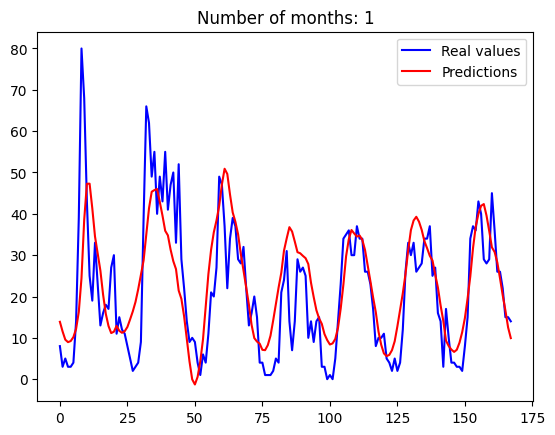

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0579 - val_loss: 0.0226
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0329 - val_loss: 0.0190
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0261 - val_loss: 0.0147
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0186 - val_loss: 0.0131
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0175 - val_loss: 0.0161
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0175 - val_loss: 0.0128
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0163 - val_loss: 0.0115
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0145 - val_loss: 0.0115
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0152 - val_loss: 0.0114
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0

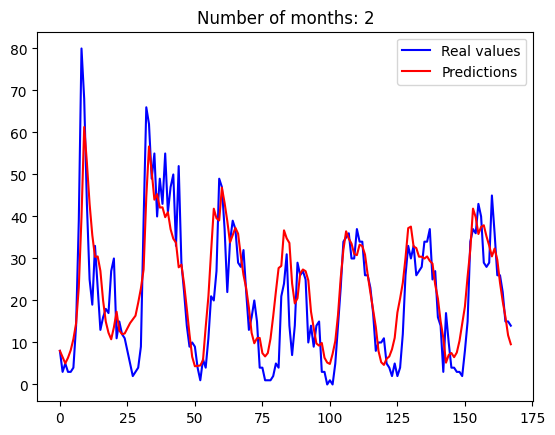

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0487 - val_loss: 0.0203
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0262 - val_loss: 0.0135
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0184 - val_loss: 0.0120
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0171 - val_loss: 0.0118
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0143 - val_loss: 0.0115
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0148 - val_loss: 0.0109
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0143 - val_loss: 0.0106
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0122 - val_loss: 0.0093
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0116 - val_loss: 0.0090
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0

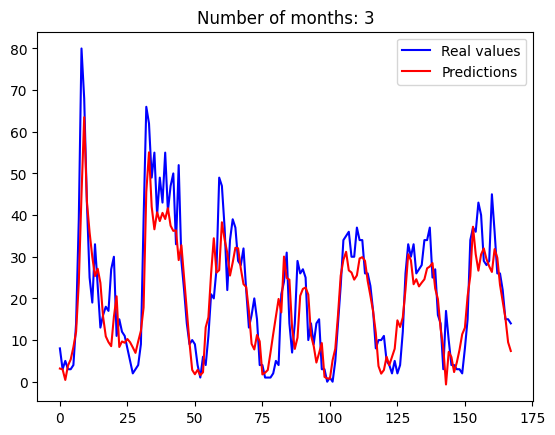

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0457 - val_loss: 0.0193
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0225 - val_loss: 0.0147
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0176 - val_loss: 0.0124
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0142 - val_loss: 0.0110
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0118 - val_loss: 0.0095
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0112 - val_loss: 0.0086
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0099 - val_loss: 0.0078
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0

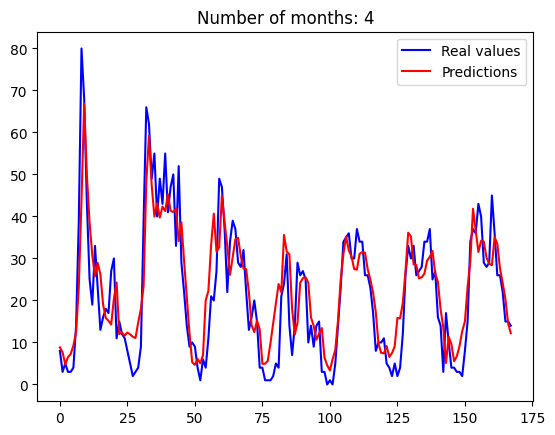

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0428 - val_loss: 0.0198
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0211 - val_loss: 0.0147
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0167 - val_loss: 0.0115
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0158 - val_loss: 0.0114
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0127 - val_loss: 0.0098
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0118 - val_loss: 0.0095
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0115 - val_loss: 0.0091
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0092 - val_loss: 0.0088
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0105 - val_loss: 0.0091
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0099 - val_loss: 0.0073
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0

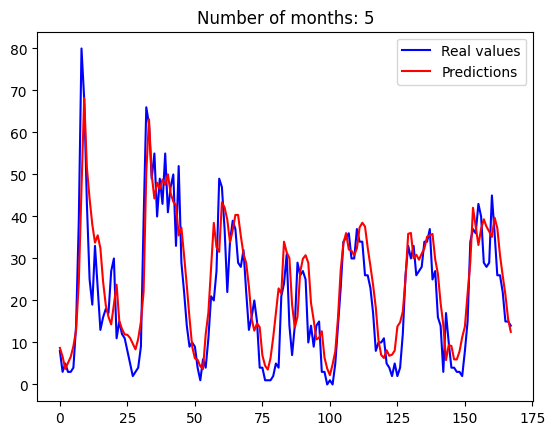

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0344 - val_loss: 0.0151
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0128 - val_loss: 0.0108
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0109 - val_loss: 0.0089
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0102 - val_loss: 0.0081
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0092 - val_loss: 0.0071
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0

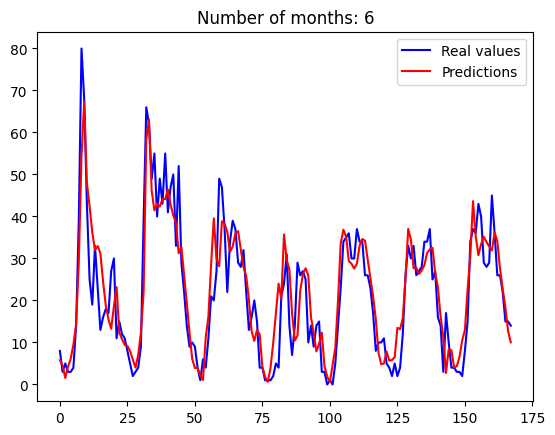

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0448 - val_loss: 0.0133
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0167 - val_loss: 0.0113
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0149 - val_loss: 0.0099
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0118 - val_loss: 0.0099
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0134 - val_loss: 0.0087
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0098 - val_loss: 0.0064
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0094 - val_loss: 0.0075
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0079 - val_loss: 0.0063
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0073 - val_loss: 0.0059
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

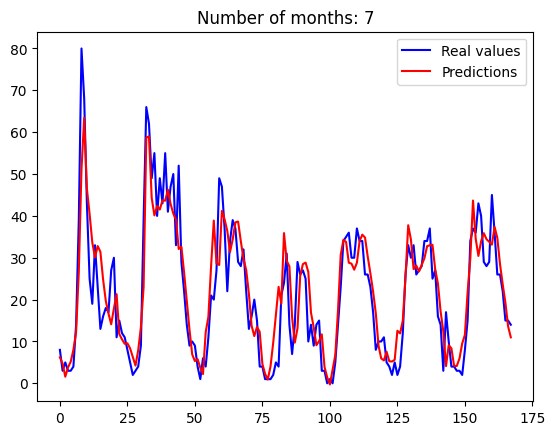

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0408 - val_loss: 0.0169
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0163 - val_loss: 0.0112
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0148 - val_loss: 0.0115
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0121 - val_loss: 0.0091
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0111 - val_loss: 0.0081
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0094 - val_loss: 0.0062
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

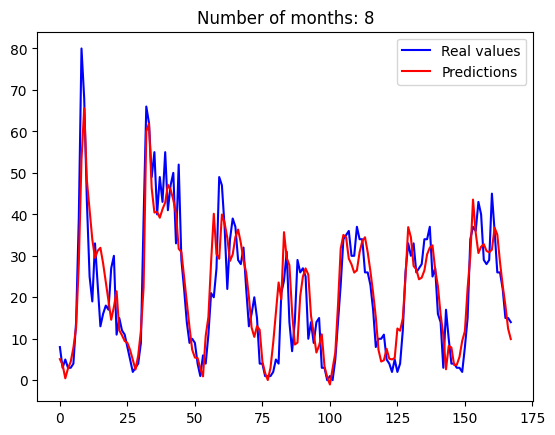

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0431 - val_loss: 0.0125
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0157 - val_loss: 0.0100
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0148 - val_loss: 0.0103
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0117 - val_loss: 0.0082
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0109 - val_loss: 0.0066
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0091 - val_loss: 0.0060
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0083 - val_loss: 0.0060
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 10/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 11/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0074 - val_loss: 0.0066
Epoch 12/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

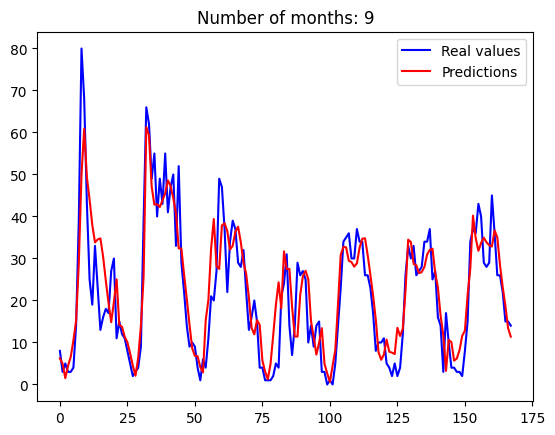

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0337 - val_loss: 0.0121
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0161 - val_loss: 0.0097
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0131 - val_loss: 0.0091
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0101 - val_loss: 0.0061
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0070 - val_loss: 0.0054
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 9/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0074 - val_loss: 0.0054
Epoch 10/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 11/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 12/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0

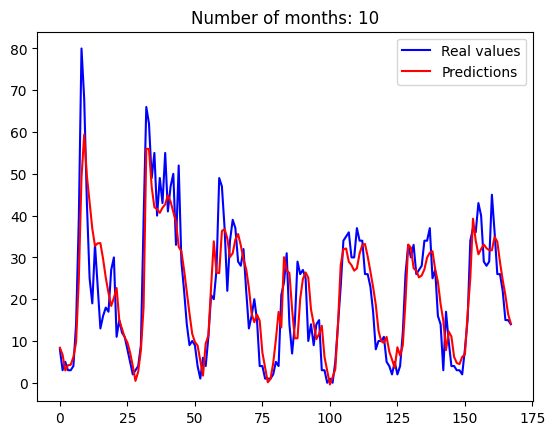

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0293 - val_loss: 0.0134
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0150 - val_loss: 0.0092
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0117 - val_loss: 0.0093
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0106 - val_loss: 0.0063
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0083 - val_loss: 0.0062
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0083 - val_loss: 0.0055
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0079 - val_loss: 0.0058
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0068 - val_loss: 0.0057
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

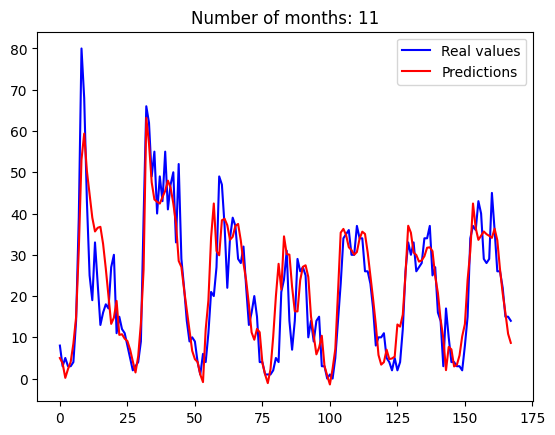

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0347 - val_loss: 0.0120
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0144 - val_loss: 0.0098
Epoch 3/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0115 - val_loss: 0.0077
Epoch 4/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0096 - val_loss: 0.0067
Epoch 5/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0077 - val_loss: 0.0062
Epoch 6/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0074 - val_loss: 0.0061
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0076 - val_loss: 0.0050
Epoch 8/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0070 - val_loss: 0.0052
Epoch 9/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0071 - val_loss: 0.0054
Epoch 10/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 10: early stopping
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


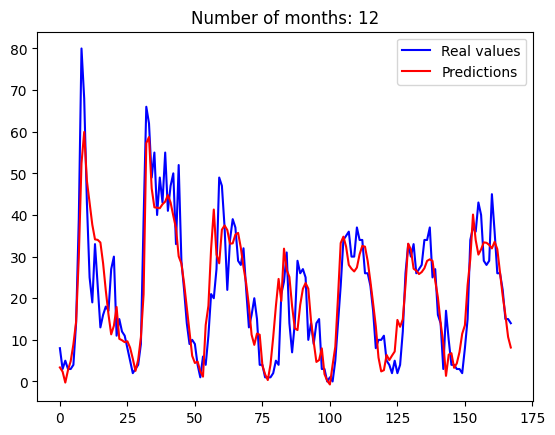

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0311 - val_loss: 0.0139
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0141 - val_loss: 0.0091
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0091 - val_loss: 0.0055
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0075 - val_loss: 0.0056
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0075 - val_loss: 0.0053
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0064 - val_loss: 0.0050
Epoch 10/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 11/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 12/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0

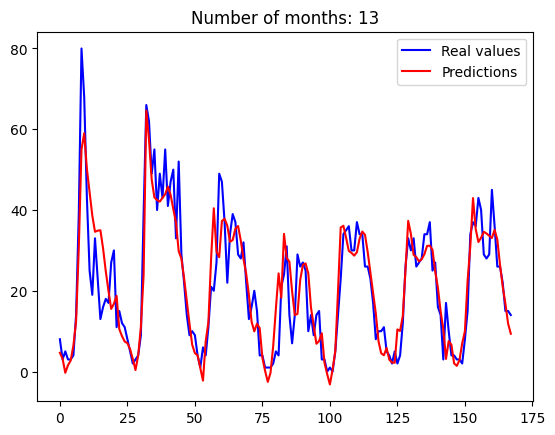

Epoch 1/100


/home/lucaserf/tiniMLVM/experiments_venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0327 - val_loss: 0.0113
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0166 - val_loss: 0.0093
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0088 - val_loss: 0.0058
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0078 - val_loss: 0.0059
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 9/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 10/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 11/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 12/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 

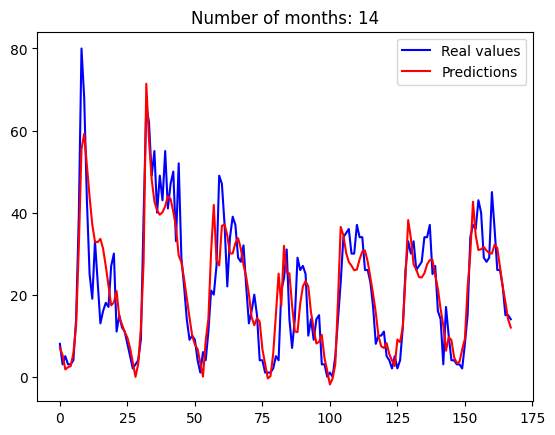

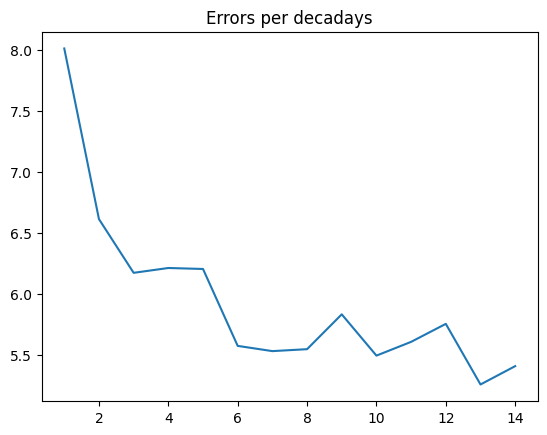

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#load the dataset

df = pd.read_csv("./sensor_data/spire_1_[44.4985349106485, 11.3541657967424].csv")

#train the model

X_data = []
y_data = []

previous_values = 24

for i in range(previous_values, len(df)):
    X_data.append(df.iloc[i - previous_values:i, 0].values)
    y_data.append(df.iloc[i, 0])

X_data, y_data = np.array(X_data), np.array(y_data)

#normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

X_data = scaler.fit_transform(X_data)
y_data = scaler.fit_transform(y_data.reshape(-1, 1))

months_errors = []

for i in range(1,15):
    period = i*10

    #take the last week for testing
    X_test = X_data[-24*7:]
    y_test = y_data[-24*7:]

    #shift the data of 3 months to offset the recency
    shift = 24*3*30

    #select the previous months before the test set
    X_train = X_data[-period*24 - 24*7- shift:-24*7 - shift]
    y_train = y_data[-period*24 - 24*7- shift:-24*7- shift]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


    #define callbacks for early stopping with validation loss

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            verbose=1
        )
    ]


    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128, input_shape=(previous_values,1), return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

    model.evaluate(X_test, y_test)

    #show the predictions on the test set

    predictions = model.predict(X_test)

    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)

    #get magnitude of the errors

    errors = np.abs(predictions - y_test)

    error = np.mean(errors)

    months_errors.append(error)

    plt.plot(y_test, color='blue', label='Real values')

    plt.plot(predictions, color='red', label='Predictions')

    plt.legend()
    plt.title(f"Number of months: {i}")

    plt.show()

#set integer values for the months

plt.plot([i for i in range(1, 15)], months_errors)
plt.title("Errors per decadays")

plt.savefig("./errors_per_decadays.png")




In [40]:
#print distributions

import os
import pandas as pd
import matplotlib.pyplot as plt

path0 = "./sensor_manager/spire/6_[44.4895074220971, 11.3433581064329]/reference_0.csv"

path1 = "./sensor_manager/spire/6_[44.4895074220971, 11.3433581064329]/reference_1.csv"

df0 = pd.read_csv(path0)
df1 = pd.read_csv(path1)




plt.hist(df0, bins=50, alpha=0.5, label='Reference 0')
plt.hist(df1, bins=50, alpha=0.5, label='Reference 1')

plt.legend()
plt.title("Distributions of the values of the sensor")

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './sensor_manager/spire/6_[44.4895074220971, 11.3433581064329]/reference_1.csv'

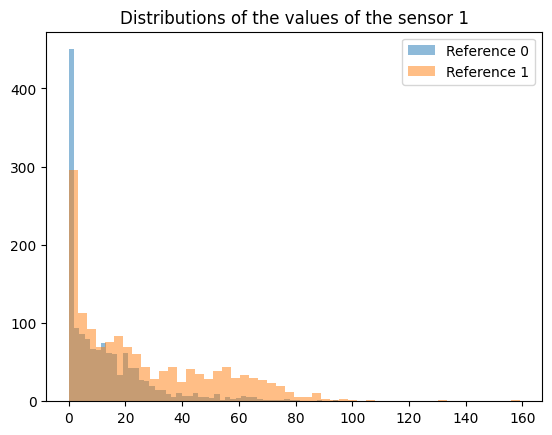

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

path0 = "./spire/5_[44.4901162203284, 11.3398356513878]/reference_4.csv"

path1 = "./spire/5_[44.4901162203284, 11.3398356513878]/reference_5.csv"


df0 = pd.read_csv(path0)
df1 = pd.read_csv(path1)




plt.hist(df0, bins=50, alpha=0.5, label='Reference 0')
plt.hist(df1, bins=50, alpha=0.5, label='Reference 1')

plt.legend()
plt.title("Distributions of the values of the sensor 1")

plt.show()